In [1]:
#!pip install pydot

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd

# Read Data

In [3]:
data = pkl.load(open('data.pkl', 'rb'))

X_input_train = data['X_input_train']
X_output_train1 = data['X_output_train']
X_input_test = data['X_input_test']
X_output_test1 = data['X_output_test']

x1_trend_param = 1
x2_trend_param = 1
x_train_max = data['x_train_max']

X_output_train = X_output_train1
X_output_test  = X_output_test1
#X_output_train = np.expand_dims(X_output_train1, axis=-1)
#X_output_test  = np.expand_dims(X_output_test1, axis=-1)

In [4]:
print('X_input_train', X_input_train.shape, 
          'X_output_train', X_output_train.shape, 
          'X_input_test', X_input_test.shape, 
          'X_output_test', X_output_test.shape, 
          'x_train_max', x_train_max.shape)

X_input_train (1262, 200, 83) X_output_train (1262, 20, 83) X_input_test (347, 200, 83) X_output_test (347, 20, 83) x_train_max (84,)


In [5]:
x_train_max

array([4.20720000e+02, 4.19740000e+02, 4.18920000e+02, 4.19460000e+02,
       1.14344770e+09, 8.46102685e+01, 1.00000000e+02, 7.97153963e+00,
       1.78827741e+00, 4.19265138e+02, 4.18171889e+02, 4.16945915e+02,
       4.15109761e+02, 4.12305693e+02, 4.18205000e+02, 2.37960201e-01,
       1.85394444e+01, 2.86006826e+02, 6.40035707e+01, 8.69640040e-01,
       4.20720000e+02, 1.15867539e+01, 1.47341968e+01, 1.83995547e+01,
       2.44547215e+01, 3.16049880e+01, 3.58120933e+01, 9.65641940e+00,
       7.46548256e+00, 2.75136738e+10, 1.08255872e+10, 6.48751931e+08,
       2.52205106e+01, 1.00000000e+02, 4.17604203e+02, 3.61300000e+01,
       5.14749315e+01, 1.00000000e+02, 9.99188963e+01, 4.15835784e+02,
       4.24994079e+02, 4.11713856e+02, 5.69519132e+01, 7.82000000e+01,
       3.89000000e+01, 2.50000000e+01, 3.22000000e+01, 1.01000000e+02,
       3.91000000e+01, 5.03000000e+01, 2.60000000e+00, 4.90000000e+00,
       3.40000000e+00, 6.20000000e+00, 7.00000000e+00, 1.12000000e+01,
      

In [6]:
X_input_train.shape, X_output_train.shape

((1262, 200, 83), (1262, 20, 83))

# Model
[Image of Luong Attention](https://github.com/HuangWeiKulish/Forecasting/blob/master/seq2seq.png?raw=true)

In [7]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
n_hidden = 100
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 82), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 82), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [8]:
input_train, output_train

(<KerasTensor: shape=(None, 200, 82) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(None, 20, 82) dtype=float32 (created by layer 'input_2')>)

#### What to Return using LSTM
- __*return_sequences=False, return_state=False*__: the last hidden state: state_h
- __*return_sequences=True, return_state=False*__: return stacked hidden states (num_timesteps * num_cells): one hidden state output for each input time step
- __*return_sequences=False, return_state=True*__: generate 3 arrays: state_h, state_h, state_c
- __*return_sequences=True, return_state=True*__: generate 3 arrays: stacked hidden states, last state_h, last state_c

In [9]:
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/strided_slice_3:0', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")


In [10]:
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1) 
print(encoder_last_h1)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='batch_normalization/batchnorm/add_1:0', description="created by layer 'batch_normalization'")


In [11]:
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c) 
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='batch_normalization_1/batchnorm/add_1:0', description="created by layer 'batch_normalization_1'")


In [12]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")


In [13]:
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
               return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")


In [14]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
#out = Dense(1)(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 82), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


In [15]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 82)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 73200       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         lstm[0][0]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 20, 100)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

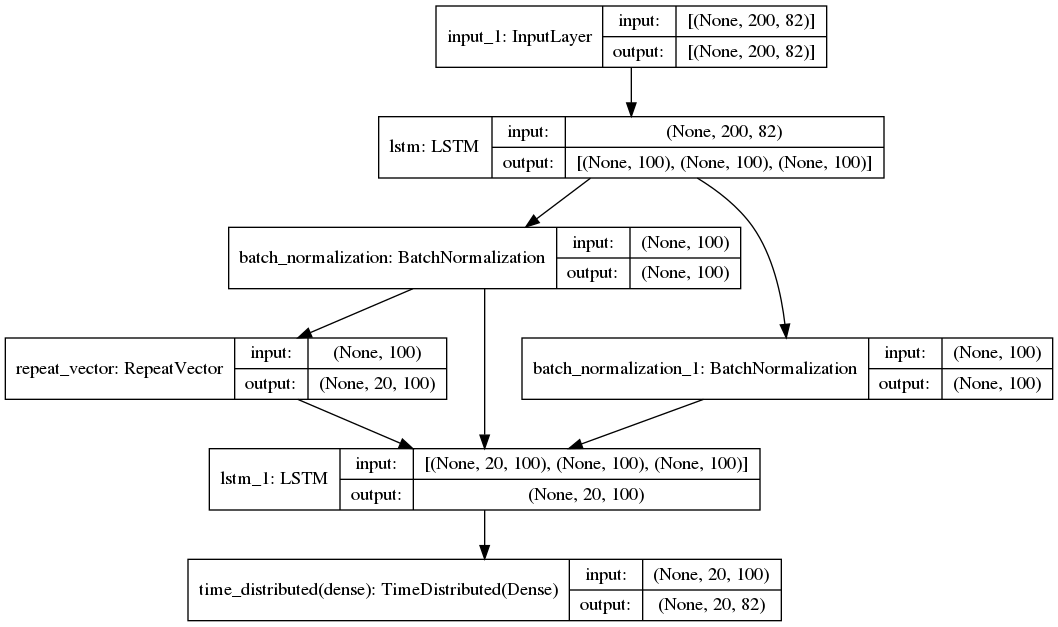

In [16]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
X_input_train.shape, X_output_train.shape

((1262, 200, 83), (1262, 20, 83))

In [18]:
X_input_train[:, :, :].shape, X_output_train[:, :, :].shape

((1262, 200, 83), (1262, 20, 83))

In [19]:
array_sum = np.sum(X_input_train)
array_has_nan = np.isnan(array_sum)
print(array_has_nan)

False


In [23]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :82], X_output_train[:, :, :82], validation_split=0.3, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('forecasting_model_seq2seq.h5')

Epoch 1/100
9/9 [==============================] - 3s 388ms/step - loss: 0.1031 - mae: 0.2108 - val_loss: 0.1170 - val_mae: 0.3121
Epoch 2/100
9/9 [==============================] - 3s 375ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/100
9/9 [==============================] - 3s 379ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/100
9/9 [==============================] - 3s 381ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/100
7/9 [======================>.......] - ETA: 0s - loss: nan - mae: nan

KeyboardInterrupt: 

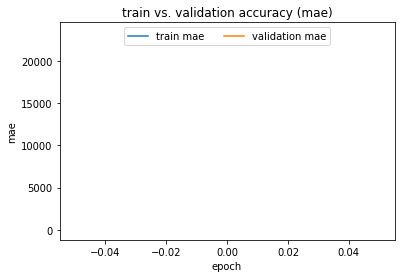

In [21]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', fancybox=True, shadow=False, ncol=2)
plt.show()

# Predict

In [22]:
train_pred_detrend = model.predict(X_input_train[:, :, :])#*x_train_max[:]
test_pred_detrend = model.predict(X_input_test[:, :, :])#*x_train_max[:]
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = X_output_train[:, :, :]*x_train_max[:]
test_true_detrend = X_output_test[:, :, :]*x_train_max[:]
print(train_pred_detrend.shape, test_pred_detrend.shape)

ValueError: in user code:

    /home/skycam/venv3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /home/skycam/venv3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/skycam/venv3.6/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/skycam/venv3.6/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/skycam/venv3.6/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/skycam/venv3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /home/skycam/venv3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /home/skycam/venv3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/skycam/venv3.6/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 200, 82), found shape=(None, 200, 83)


In [ ]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

In [ ]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show() 

In [ ]:
for lb in ['train', 'test']:
    ith_sample = random.choice(range(data_final[lb+'_pred'].shape[0]))

    plt.figure(figsize=(15,3))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][ith_sample, :, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][ith_sample, :, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th sample'.format(lb, ith_sample))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()

In [ ]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
for lb in ['train', 'test']:   
    plt.figure(figsize=(15, 5))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()


In [ ]:
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
    
plt.title('{}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()